In [11]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [12]:
import argparse

import baal
from baal import ActiveLearningDataset
from baal.active import get_heuristic, ActiveLearningLoop
from baal.bayesian.dropout import MCDropoutModule
from copy import deepcopy

import numpy as np

import segmentation_models_pytorch as smp

from PIL import Image
from pprint import pprint

import torch
from torch import nn
from torch.nn import functional as F

from torchvision.transforms import transforms
from torch.cuda.amp import GradScaler, autocast


from tqdm import tqdm

from typing import List


In [13]:
debug=False

print("Pytorch: \t\t", torch.__version__)
if not debug and torch.cuda.is_available():
    device='cuda'
    print('GPU:         \t\t', torch.cuda.get_device_name(0))
    print('Memory Usage:\t',
        round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB / ',
        round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    torch.backends.cudnn.benchmark = True
else:
    print("GPU is **not available**")
    device='cpu'

Pytorch: 		 1.13.0+cu116
GPU:         		 NVIDIA A100 80GB PCIe MIG 2g.20gb
Memory Usage:	 0.0 GB /  0.0 GB


In [14]:
# Initialization
%load_ext autoreload
%autoreload 2
import sys
import os
import pathlib

# To be able to reference packages/modules in this repository, this
# relative path must be added to the python path. Your notebook may be 
# in a different folder, so modify this variable to point to the src 
# folder.
proj_notebooks_root = pathlib.Path().absolute()
proj_root_path = proj_notebooks_root.parent
data_path = proj_notebooks_root / "data"

if proj_root_path not in sys.path:
    sys.path.insert(0, proj_root_path.as_posix())
    print("Updated Python Path")

print(f"Project Root Path: {proj_root_path}")
print(f"Project Source Root Path: {proj_notebooks_root}")
print(f"Project Data Path: {data_path}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Updated Python Path
Project Root Path: /home/default/workspace
Project Source Root Path: /home/default/workspace/ActiveLearning
Project Data Path: /home/default/workspace/ActiveLearning/data


In [15]:
import zipfile

base_dir = data_path / 'deepcrack'
if not base_dir.exists():
    ! wget -O {data_path / 'DeepCrack.zip'} https://github.com/yhlleo/DeepCrack/raw/master/dataset/DeepCrack.zip 
#     ! kaggle datasets download -p {data_path.as_posix()} -d lakshaymiddha/crack-segmentation-dataset
    with zipfile.ZipFile(data_path / 'DeepCrack.zip', 'r') as zip_ref:
        zip_ref.extractall(base_dir)

    ! rm {data_path / 'DeepCrack.zip'} 
else:
    print("Found dataset at ", base_dir.as_posix())


Found dataset at  /home/default/workspace/ActiveLearning/data/deepcrack


In [16]:
class FocalLoss(nn.Module):
    """
    References:
        Author: clcarwin
        Site https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py
    """

    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.data.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            select = (target != 0).type(torch.LongTensor).to(self.alpha.device)
            at = self.alpha.gather(0, select.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [17]:
def mean_regions(n, grid_size=16):
    # Compute the mean uncertainty per regions.
    # [batch_size, W, H]
    n = torch.from_numpy(n[:, None, ...])
    # [Batch_size, 1, grid, grid]
    out = F.adaptive_avg_pool2d(n, grid_size)
    return np.mean(out.view([-1, grid_size**2]).numpy(), -1)


class ArrayDataset(torch.utils.data.Dataset):
    def __init__(self, array, image_transforms=None, segment_transforms=None):
        self.array = array
                
        self.image_transforms = image_transforms
        self.segment_transforms = segment_transforms
        
        if segment_transforms is None:
            self.segment_transforms = transforms.Compose([
                transforms.ToTensor()
            ])

    def __len__(self):
        return len(self.array)

    def __getitem__(self, index):
        imagePath, segmentPath = self.array[index]
        image = Image.open(imagePath).convert('RGB')
        segment = Image.open(segmentPath).convert('L')
        segment = self.segment_transforms(segment)        
            
        if self.image_transforms is not None:
            image = self.image_transforms(image)
        
        # print(image.shape, segment.shape)

#         if image.shape != (3, 448, 448):
#             print(f"Image shape is {image.shape}")
#         if segment.shape != (1, 448, 448):
#             print(f"Segment shape is {segment.shape}")
        
        return image, segment.type(torch.int64) 
    
    def split(self, p=0.5):
        count = len(self.array)
        index = np.arange(count)
        first = int(count * p)
        return [
            ArrayDataset(self.array[index[:first]], 
                    image_transforms=self.image_transforms,
                    segment_transforms=self.segment_transforms), 
            ArrayDataset(self.array[index[first:]], 
                    image_transforms=self.image_transforms,
                    segment_transforms=self.segment_transforms)
        ]
    
    def split_count(self, first):
        return [
            ArrayDataset(self.array[:first], 
                    image_transforms=self.image_transforms,
                    segment_transforms=self.segment_transforms),
            ArrayDataset(self.array[first:], 
                    image_transforms=self.image_transforms,
                    segment_transforms=self.segment_transforms)
        ]

def get_datasets(initial_pool, path):
    image_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    segment_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor()
        ])
    
    X_dir = path/'test_img'
    y_dir = path/'test_lab'

    files = [y for y in X_dir.glob('*')]

    for i in files:
        assert((y_dir / (i.stem + ".png")).exists())
    data = [(x, (y_dir / (x.stem + ".png"))) for x in X_dir.glob('*')] 

    test_set = ArrayDataset(data, 
                           image_transforms = image_transform, 
                           segment_transforms = segment_transform)


    X_dir = path/'train_img'
    y_dir = path/'train_lab'

    files = [y for y in X_dir.glob('*')]

    for i in files:
        assert((y_dir / (i.stem + ".png")).exists())

    data = [(x, (y_dir / (x.stem + ".png"))) for x in X_dir.glob('*')] 

    active_set = ArrayDataset(data, 
                           image_transforms = image_transform, 
                           segment_transforms = segment_transform)


#     test_set, active_set = dataset.split_count(30)
    print("Active Set: ", len(active_set))
    print("Test Set: ", len(test_set))
    
    active_set = ActiveLearningDataset(active_set)
    
    active_set.label_randomly(initial_pool)
    return active_set, test_set

In [18]:
p_active_learning_steps = 4

p_initial_pool = 100
p_query_size = 20
p_query_interations = 20

p_heuristic = "random"
p_reduce="sum"

p_learning_epochs=20
p_batch_size = 128
p_learning_rate = 0.001

p_classes = 2

use_cuda = torch.cuda.is_available()
# use_cuda = False
print("Use Cuda:", use_cuda)

Use Cuda: True


In [19]:

def get_eval_metrics(pred, gold, threshold = 0.5):
#     print(pred.shape, gold.shape)
    assert pred.shape == gold.shape
    pred = (pred > threshold).long()
    gold = gold.long()
    hits = torch.sum(pred * gold).item() #element-wise multiplication
    shots = torch.sum(pred).item()
    targets = torch.sum(gold).item()
#     print(hits, shots, targets)
    return hits, shots, targets

def train_loop(dataloader, model, loss_fn, optimizer, scaler, history=None, lr_sched=None):
    size = len(dataloader.dataset)
    model.train()
    loss_sum = 0
    total_hits = 0
    total_shots = 0
    total_targets = 0
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        # Runs the forward pass with autocasting.
        with autocast():
            output = model(X)
            loss = loss_fn(output, y)

            hits, shots, targets = get_eval_metrics(output[:,1], y.squeeze())
            total_hits += hits
            total_shots += shots
            total_targets += targets

        # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
        # Backward passes under autocast are not recommended.
        # Backward ops run in the same dtype autocast chose for corresponding forward ops.
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()

        loss_sum += loss.item()

        if(lr_sched is not None):
            lr_sched.step()

    history['train_loss'].append(loss_sum/len(dataloader))
    history['train_hits'].append(total_hits)
    history['train_shots'].append(total_shots)
    history['train_targets'].append(total_targets)
    
    if total_hits == 0 or total_shots == 0:
        precision = 0
        recall = 0
        f1score = 0
    else:
        precision = total_hits/total_shots
        recall = total_hits/total_targets
        f1score = (2 * precision * recall)/(precision + recall)
        

    history['train_precision'].append(precision)
    history['train_recall'].append(recall)
    history['train_f1score'].append(f1score)


def test_loop(dataloader, model, loss_fn, history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss = 0
    total_hits = 0
    total_shots = 0
    total_targets = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
#             print(y.shape)
            
            output = model(X)
            
            loss += loss_fn(output, y).item()
            hits, shots, targets = get_eval_metrics(output[:,1], y.squeeze())
            total_hits += hits
            total_shots += shots
            total_targets += targets

    loss /= num_batches
    history['test_loss'].append(loss)
    history['test_hits'].append(total_hits)
    history['test_shots'].append(total_shots)
    history['test_targets'].append(total_targets)
    
    if total_hits == 0 or total_shots == 0:
        precision = 0
        recall = 0
        f1score = 0
    else:
        precision = total_hits/total_shots
        recall = total_hits/total_targets
        f1score = (2 * precision * recall)/(precision + recall)
        

    history['test_precision'].append(precision)
    history['test_recall'].append(recall)
    history['test_f1score'].append(f1score)


def train_model(model_wrapper, loss_fn, train_dataset, test_dataset,epochs=40):
    history = {
        'train_loss':[],
        'train_hits':[],
        'train_shots':[],
        'train_targets':[],
        'train_precision': [],
        'train_recall': [],
        'train_f1score': [],
        'test_loss':[],
        'test_hits':[],
        'test_shots':[],
        'test_targets':[],
        'test_precision': [],
        'test_recall': [],
        'test_f1score': []
    }

    model_wrapper.model
    train_dataloader = torch.utils.data.DataLoader(train_dataset,
                            batch_size=p_batch_size,
                            shuffle=True,
                            prefetch_factor=2,
                            pin_memory=True,
                            num_workers=8)

    test_dataloader = torch.utils.data.DataLoader(test_dataset,
                            batch_size=p_batch_size,
                            shuffle=False,
                            num_workers=8)
        
    scaler = GradScaler()
    params = [p for p in model_wrapper.model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params, 
        lr=p_learning_rate, 
        momentum=0.9, 
        weight_decay=5e-4)

#     lr_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
#                        max_lr=0.01, 
#                        steps_per_epoch=len(train_dataloader), 
#                        epochs=epochs)

    for t in tqdm(range(epochs), bar_format="{elapsed} Elapsed | {percentage:3.0f}% done |{bar}| {n_fmt}/{total_fmt} [{remaining} remaining | {rate_fmt}{postfix}]", unit="epoch", total=epochs):
#         dataloader, model, loss_fn, optimizer, scaler, history=None
        train_loop(train_dataloader, model_wrapper.model, loss_fn, optimizer, 
                   scaler, history)
        test_loop(test_dataloader, model_wrapper.model, loss_fn, history)

    return model, history

In [20]:

# We will use the FocalLoss
if p_classes > 1:
    criterion = FocalLoss(gamma=2, alpha=0.25)
else:
    criterion = nn.BCEWithLogitsLoss()

# 
# model = smp.Unet(
#     encoder_name="resnext50_32x4d",
#     encoder_depth=5,
#     encoder_weights="imagenet",
#     decoder_use_batchnorm=False,
#     classes=1,
# )
# add_dropout(model, classes=1, activation=None)

model = smp.Unet('resnet34', 
                 classes=p_classes,
                 encoder_weights="imagenet",
                 decoder_use_batchnorm=False)
model.segmentation_head[1] = nn.Dropout2d(0.5)


# This will enable Dropout at test time.
model = MCDropoutModule(model)

# Put everything on GPU.
if use_cuda:
    model.cuda()

# Keep a copy of the original weights
initial_weights = deepcopy(model.state_dict())

# Add metrics
model = baal.ModelWrapper(model, criterion, replicate_in_memory=False)

Active Set:  300
Test Set:  237
(256, 256, 3) torch.Size([1, 256, 256])
(256, 256, 3) torch.Size([1, 256, 256])


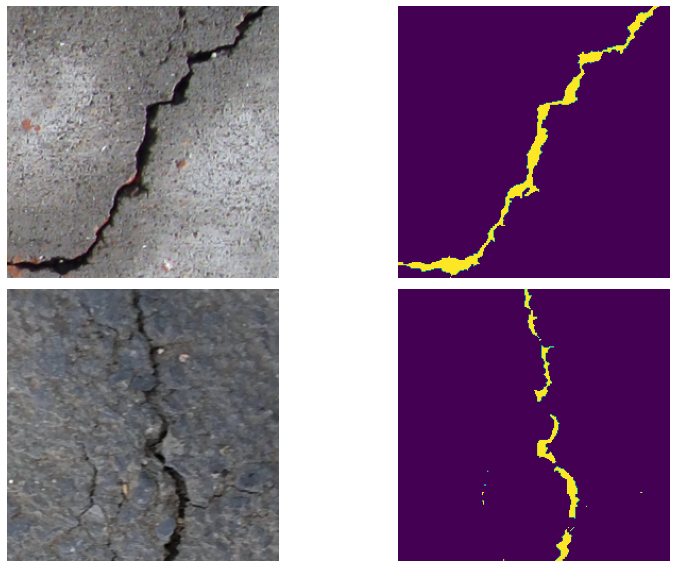

In [27]:
import matplotlib.pyplot as plt

active_set, test_set = get_datasets(p_initial_pool, base_dir)

test_dataloader = torch.utils.data.DataLoader(test_set,
                        batch_size=p_batch_size,
                        shuffle=False,
                        num_workers=8)

batch = next(iter(test_dataloader))
tensors = batch[0]
segments = batch[1]

# tensors, metadata
y = 2; x = 2
fig = plt.figure(figsize=(8*x, 4*y))

for i in range(y):
#     print(y*100 + x*10 + i)
    ax = fig.add_subplot(y , x , (i*2) + 1)
    image = tensors[i].permute(1,2,0).cpu().numpy()
    print(image.shape, segments[i].shape)
    image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
    image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    
    ax = fig.add_subplot(y , x , (i*2) + 2)
    image = segments[i].cpu().numpy()
    image = np.squeeze(image)
#     image = np.atleast_3d(image)
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    


In [ ]:
heuristics = ['random'] #, 'certainty', 'entropy', 'bald'
all_histories = []
for h in heuristics:
    print("="*20)
    print(f"Heuristic: {h}")
    print("="*20)
    if h == 'batch_bald':
        heuristic = get_heuristic(h, reduction=mean_regions, num_samples=1000)
    else:
        heuristic = get_heuristic(h, reduction=mean_regions)

    active_set, test_set = get_datasets(p_initial_pool, base_dir)

    image, segment = active_set[0]
    image.shape, segment.shape

    # The ALLoop is in charge of predicting the uncertainty and
    loop = ActiveLearningLoop(
        active_set,
        model.predict_on_dataset_generator,
        heuristic=heuristic,
        query_size=p_query_size,
        # Instead of predicting on the entire pool, only a subset is used
        max_sample=1000,
        batch_size=p_batch_size,
        iterations=p_query_interations,
        use_cuda=use_cuda,
    )
    history = []
    all_histories.append(history)
    for epoch in range(p_active_learning_steps):
        print(f"Step: {epoch + 1}")
        # Following Gal et al. 2016, we reset the weights.
        model.load_state_dict(initial_weights)
        # Train 50 epochs before sampling.

        print("Training Model...")
        model, stats = train_model(model, criterion, 
                                   active_set, test_set, 
                                   epochs=p_learning_epochs)
        history.append(stats)
        print("Last Training:")
        for i in stats:
            print(f"{i:10}:{stats[i][-1]:.3f}")
        print("Querying...")

        should_continue = loop.step()

        print("-"*20)
        
        if not should_continue:
            break
    print("Training Final Model...")
    model, stats = train_model(model, criterion, 
                               active_set, test_set, 
                               epochs=p_learning_epochs)
    history.append(stats)

# ~ 4 minutes per training
# ~ 16 minutes per heuristic

Heuristic: random
Active Set:  300
Test Set:  237
Step: 1
Training Model...


02:23 Elapsed | 100% done |██████████| 20/20 [00:00 remaining |  7.18s/epoch]

Last Training:
train_loss:0.034
train_hits:52.000
train_shots:582.000
train_targets:150521.000
train_precision:0.089
train_recall:0.000
train_f1score:0.001
test_loss :0.040
test_hits :269.000
test_shots:2586.000
test_targets:564508.000
test_precision:0.104
test_recall:0.000
test_f1score:0.001
Querying...
[38660-MainThread] [baal.modelwrapper:predict_on_dataset_generator:232] 2022-12-17T02:20:32.347215Z [info     ] Start Predict                  dataset=200


100%|██████████| 2/2 [00:10<00:00,  5.38s/it]
--------------------
Step: 2
Training Model...


02:23 Elapsed | 100% done |██████████| 20/20 [00:00 remaining |  7.19s/epoch]

Last Training:
train_loss:0.035
train_hits:141.000
train_shots:2006.000
train_targets:171980.000
train_precision:0.070
train_recall:0.001
train_f1score:0.002
test_loss :0.039
test_hits :397.000
test_shots:3701.000
test_targets:564508.000
test_precision:0.107
test_recall:0.001
test_f1score:0.001
Querying...
[38660-MainThread] [baal.modelwrapper:predict_on_dataset_generator:232] 2022-12-17T02:23:06.979250Z [info     ] Start Predict                  dataset=180


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]
--------------------
Step: 3
Training Model...


02:21 Elapsed |  85% done |████████▌ | 17/20 [00:22 remaining |  7.51s/epoch]

In [ ]:
len(all_histories[-1]), all_histories[-1][0]

In [ ]:
len(all_histories), len(all_histories[0]), all_histories[0][0].keys()

In [ ]:
from datetime import datetime
import pathlib
timestamp = datetime.now().strftime("%Y%m%d%H%M")
results_dir = pathlib.Path('results')

timestamp, results_dir.exists()

In [ ]:
import json
with open(results_dir / f'{timestamp}-log.txt', 'w') as logfile:
    logfile.write(json.dumps(all_histories))

In [ ]:
# import json
# with open('data.json') as json_file:
#     data = json.load(json_file)

#     # Print the type of data variable
#     print("Type:", type(data))
#     # Print the data of dictionary
#     print("\nPeople1:", data['people1'])
#     print("\nPeople2:", data['people2'])

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

def plotHistory(history):
    metrics = ['train_loss', 'train_precision', 'train_recall', 'train_f1score',
           'test_loss','test_precision','test_recall', 'test_f1score']
    gradients = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                          'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                          'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(history))
    rows = 2
    cols = round(len(metrics)/rows)

    fig, axes = plt.subplots(rows, cols, figsize=(12,8), sharey = True)

    for index, metric in enumerate(metrics):
        cmap = matplotlib.cm.get_cmap(gradients[index])

        ax = axes[index//cols,index%cols]
        for i, val in enumerate(history):
            ax.plot(val[metric], color=cmap(norm(i)))
        ax.set_title(metric)

print("For Heuristic: ", heuristics[0])
plotHistory(all_histories[0])
plt.savefig(results_dir / f'{timestamp}-{heuristics[0]}.png', bbox_inches='tight')




In [ ]:
print("For Heuristic: ", heuristics[1])
plotHistory(all_histories[1])
plt.savefig(results_dir / f'{timestamp}-{heuristics[1]}.png', bbox_inches='tight')


In [ ]:
print("For Heuristic: ", heuristics[2])
plotHistory(all_histories[2])
plt.savefig(results_dir / f'{timestamp}-{heuristics[2]}.png', bbox_inches='tight')


In [ ]:
print("For Heuristic: ", heuristics[3])
plotHistory(all_histories[3])
plt.savefig(results_dir / f'{timestamp}-{heuristics[3]}.png', bbox_inches='tight')

In [ ]:
metrics = ['train_loss', 'train_precision', 'train_recall', 'train_f1score',
           'test_loss','test_precision','test_recall', 'test_f1score']
rows = 2
cols = round(len(metrics)/rows)

fig, axes = plt.subplots(rows, cols, figsize=(12,8), sharey = True)

for index, metric in enumerate(metrics):
    ax = axes[index//cols,index%cols]
    for i, val in enumerate(all_histories):
        ax.plot(val[-1][metric], label=heuristics[i])
    ax.set_title(metric)